In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms
from pathlib import Path
from skimage.util import random_noise
import plotly.express as px


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.CTDataModule import CTDataModule

import pytorch_lightning as pl

from src.predictions import get_test_predictions
from src.neural_network import DeepSymNet
from src.utils import show_tensor, plot_tensors
from src.CTDataModule import crop_black_and_white_loader
from src.image_transforms import AddGaussianNoise



# Модель и картинки

## Загрузка модели

In [5]:
path_local_models = Path("/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/lightning_logs/")

path_model  = path_local_models / "BEST_ish_lr/checkpoints/epoch=62-step=252.ckpt"

model = DeepSymNet.load_from_checkpoint(path_model)
model.eval()

DeepSymNet(
  (siamese_part): SiameseAndDifferenceBlock(
    (inception_chain): Sequential(
      (0): InceptionBlock(
        (branch_1filter): ConvBlock(
          (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (branch_3filter): Sequential(
          (0): ConvBlock(
            (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (branch_5filter): Sequential(
          (0): ConvBlock(
            (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

## Загрузка картинок

### датамодуль тест

In [72]:
# whole test set
test_dir = "/home/martinumer/IschemicData/test"
dm_predict = CTDataModule(data_dir=test_dir,
                              batch_size=1,
                              num_workers=6,
                              test_shuffle=False)
dm_predict.setup('test')
dataloader = dm_predict.test_dataloader()
dataloader_iter = iter(dataloader)

img, label = next(dataloader_iter)

# 10 норм + 10 инсультов
images_labels = []
for i in range(10):
    img, label = next(dataloader_iter)
    images_labels.append((img, label))
n_true = 0
while n_true != 10:
    img, label = next(dataloader_iter)
    if label == 0:
        continue
    images_labels.append((img, label))
    n_true += 1

images_labels[19]

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 tensor([1]))

### наша конкретная картинка

In [6]:
# upload your own image
marked = "not_marked"
mode = "test"
num_img = "2a"
label = torch.tensor([1])

test_image =f"/home/high_fly_bird/data/attention_samples/{marked}/{mode}/{num_img}.jpg"
IMG_HEIGHT = 128
IMG_WIDTH = 98

short_img_pipeline = transforms.Compose([
    crop_black_and_white_loader,
            transforms.Resize(
                (IMG_HEIGHT, IMG_WIDTH), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
        ])

img = short_img_pipeline(test_image)
img = img.unsqueeze(dim=0)

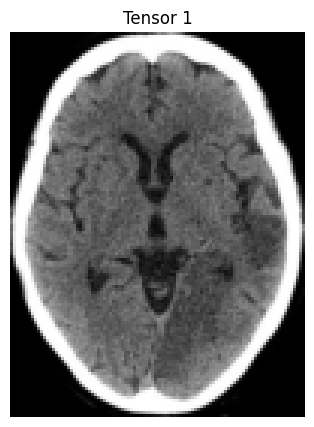

In [7]:
plot_tensors([img[0]])

### трансформы

In [8]:
# повышаем яркость, если нужно
more_clear_transform = transforms.ColorJitter(brightness=0.5, contrast=0.9, saturation=0.5, hue=0.5)
img_clear = more_clear_transform(img)

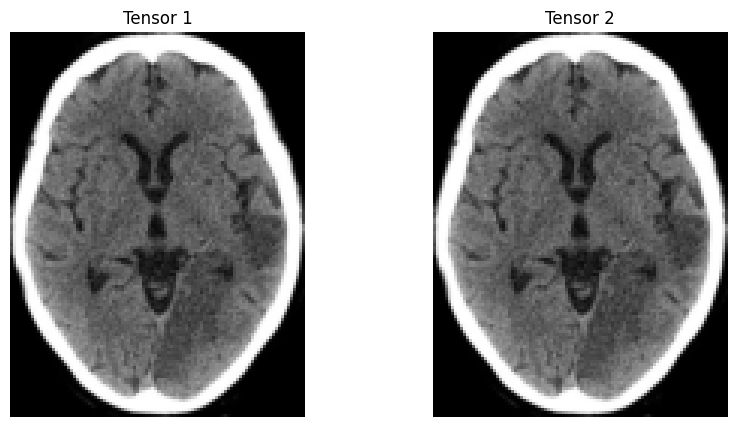

In [9]:
plot_tensors([img[0], img_clear[0]])

In [10]:
img_noisy_1 = AddGaussianNoise(0, 0.05)(img)
img_noisy_2 = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.05, clip=True))

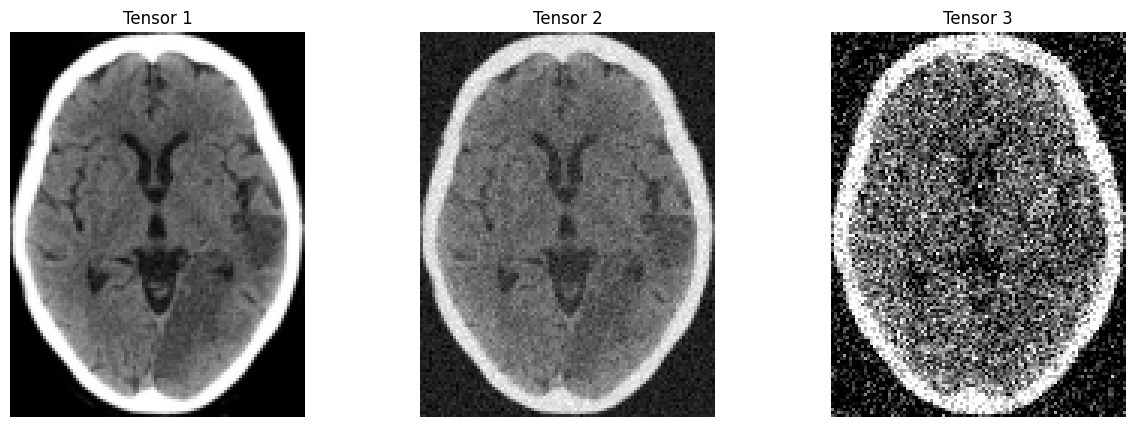

In [11]:
plot_tensors([img[0], img_noisy_1[0], img_noisy_2[0]])

## Hook

In [12]:
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# SCORE-CAM

## Инсепшены и 2д в инсепшенах

In [90]:
siamese_tunnel = list(model.children())[0]
inception_blocks = list(siamese_tunnel.children())[0]

In [91]:
# conv2ds in each inception module
conv2ds = [ list(list(inception_blocks[i].children())[0].children())[0] for i in range(4)]

In [92]:
shared_tunnel = list(list(model.children())[1].children())

In [93]:
# register hooks on each layer
hooks = [Hook(layer) for layer in inception_blocks]
hooks2 = [Hook(layer) for layer in shared_tunnel]
hooks_conv2d = [Hook(conv2d) for conv2d in conv2ds]

In [94]:
model(img)

tensor([0.0212], grad_fn=<ReshapeAliasBackward0>)

In [95]:
hooks[0].output.shape

torch.Size([2, 256, 128, 49])

In [96]:
def scorecam_whole_heatmap_for_layer(hook_output: Hook):
    left_hemisphere =  hook_output[0:img.shape[0]]
    right_hemisphere =  hook_output[img.shape[0]:]
    print(f"Hemisphere shape: {left_hemisphere.shape}")
    whole = torch.cat([left_hemisphere, right_hemisphere], dim=3)
    print(f"Whole brain shape: {whole.shape}")
    
    scores_mean = F.softmax(whole.mean((0,2,3)), dim=0)
    activations = torch.zeros(whole.shape[0], 1, whole.shape[2], whole.shape[3])
    for i in range(whole.shape[1]):
        activations += whole[:,i,:,:] * scores_mean[i]
    activations = F.relu(activations)
    print(f"Mean-multipled brain shape: {scores_mean.shape}")

    heatmap = activations.squeeze()
    heatmap = heatmap / torch.max(heatmap)
    print(f"Normalized heatmap shape {heatmap.shape}")
    return heatmap



In [ ]:
heatmaps_2d = []
for hook_conv2d in hooks_conv2d:
    conv2d_output = hook_conv2d.output
    conv2d_output[conv2d_output < 0] = 0
    spec_heatmap = scorecam_whole_heatmap_for_layer(conv2d_output)
    heatmaps_2d.append(spec_heatmap)

In [99]:
heatmaps_inception = [scorecam_whole_heatmap_for_layer(hook.output) for hook in hooks]

Hemisphere shape: torch.Size([1, 256, 128, 49])
Whole brain shape: torch.Size([1, 256, 128, 98])
Mean-multipled brain shape: torch.Size([256])
Normalized heatmap shape torch.Size([128, 98])
Hemisphere shape: torch.Size([1, 256, 128, 49])
Whole brain shape: torch.Size([1, 256, 128, 98])
Mean-multipled brain shape: torch.Size([256])
Normalized heatmap shape torch.Size([128, 98])
Hemisphere shape: torch.Size([1, 256, 128, 49])
Whole brain shape: torch.Size([1, 256, 128, 98])
Mean-multipled brain shape: torch.Size([256])
Normalized heatmap shape torch.Size([128, 98])
Hemisphere shape: torch.Size([1, 256, 128, 49])
Whole brain shape: torch.Size([1, 256, 128, 98])
Mean-multipled brain shape: torch.Size([256])
Normalized heatmap shape torch.Size([128, 98])


In [ ]:
heatmaps_two_shared = [scorecam_whole_heatmap_for_layer(hook.output) for hook in hooks]

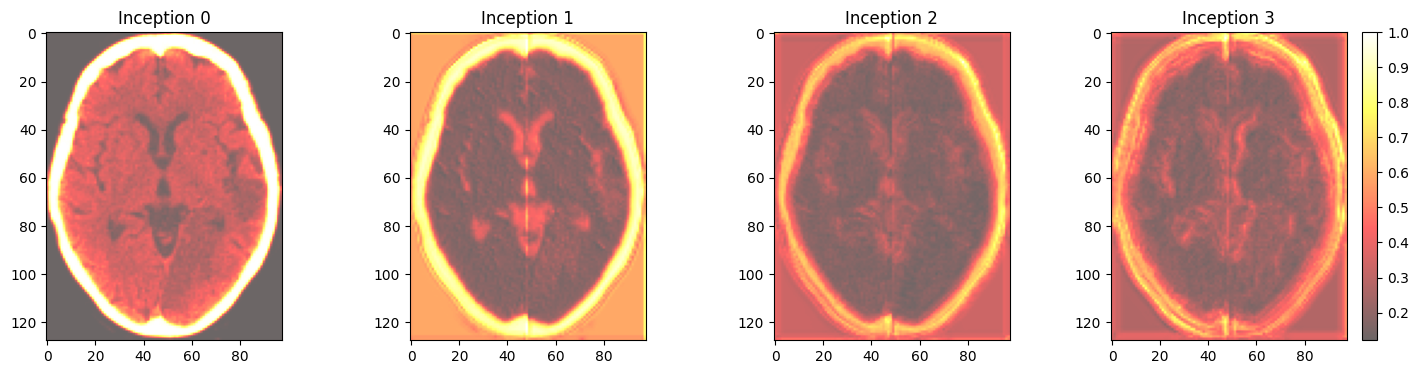

In [101]:

which_heatmaps = heatmaps_2d # heatmaps_inception

n_plots = len(which_heatmaps)
fig, axes = plt.subplots(1, n_plots, figsize=(18,4))

# plot the heatmap data on top of the original data
for i in range(n_plots):
    im = axes[i].imshow(which_heatmaps[i].detach().numpy(), cmap='hot', alpha=0.6)
    axes[i].set_title(f"Inception {i}")

# add a colorbar for the heatmap
cbar = fig.colorbar(im)
# plt.show()

In [ ]:
px.imshow(heatmaps[0].detach().numpy())

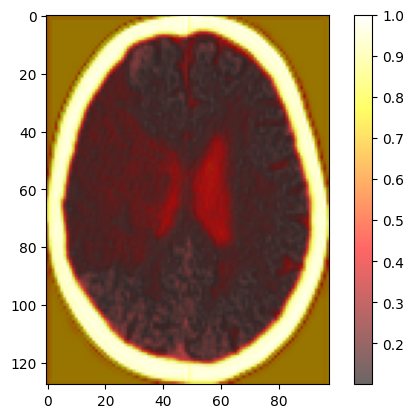

In [577]:

import matplotlib.pyplot as plt
import numpy as np

# create the first plot
fig, ax = plt.subplots()
ax.imshow(img[0].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')


# plot the heatmap data on top of the original data
im = ax.imshow(heatmap.detach().numpy(), cmap='hot', alpha=0.6)

# add a colorbar for the heatmap
cbar = fig.colorbar(im)

# show the plot
plt.show()



# Для разности (половинка мозга) (scorecam)

In [62]:
def scorecam_half_heatmap_for_layer(hook: Hook):
    output = hook.output
    output_mean = F.softmax(output.mean((0,2,3)), dim=0)
    activations = torch.zeros(output.shape[0], 1, output.shape[2], output.shape[3]) # torch.Size([1, 1, 43, 17])
    for i in range(output.shape[1]):
        activations += output[:,i,:,:] * output_mean[i] # weighted feature maps
    activations = F.relu(activations)
    heatmap = activations.squeeze()
    heatmap = heatmap / torch.max(heatmap)
    return heatmap



In [66]:
scorecam_half_heatmap_for_layer(hooks2[0]).shape

torch.Size([128, 49])

In [532]:
last_squared_block = list(list(model.children())[-2].children())[-1]
# last_squared_block = list(list(model.children())[-3].children())[-1]
last_squared_block

MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)

In [533]:
hook_half = Hook(last_squared_block)


In [534]:
model(img)

tensor([0.9813], grad_fn=<ReshapeAliasBackward0>)

In [535]:
hook_half.output.shape

torch.Size([1, 256, 43, 17])

In [536]:
output_mean = F.softmax(hook_half.output.mean((0,2,3)))
output_mean.shape

/tmp/ipykernel_4184836/2584013768.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_mean = F.softmax(hook_half.output.mean((0,2,3)))


torch.Size([256])

In [537]:
activations = torch.zeros(hook_half.output.shape[0], 1, hook_half.output.shape[2], hook_half.output.shape[3]) # torch.Size([1, 1, 43, 17])
for i in range(hook_half.output.shape[1]):
    activations += hook_half.output[:,i,:,:] * output_mean[i] # weighted feature maps
activations = F.relu(activations)
activations.shape

torch.Size([1, 1, 43, 17])

In [538]:
heatmap = activations.squeeze()

## Normalize heatmap
heatmap = heatmap / torch.max(heatmap)

heatmap.shape

torch.Size([43, 17])

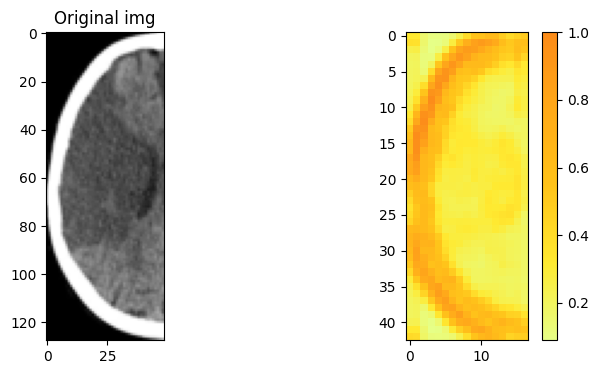

In [539]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# more orange means the highest values
im = ax2.imshow(heatmap.detach().numpy(), cmap='Wistia', alpha=0.9, interpolation='nearest')


cbar = fig.colorbar(im)
plt.show()


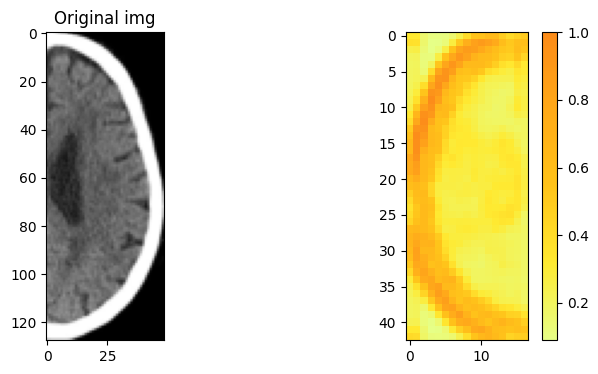

In [540]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, (98 // 2):].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# more orange means the highest values
im = ax2.imshow(heatmap.detach().numpy(), cmap='Wistia', alpha=0.9, interpolation='nearest')


cbar = fig.colorbar(im)
plt.show()


# Для разности (половинка мозга) (gradcam)

In [541]:
# получаем выход слоёв ДО предсказания
x = list(model.children())[0](img)
# получаем активации иНТЕРЕСУЮЩЕГО слоя
layer_activations = list(model.children())[1](x)
layer_activations_flat = layer_activations.view(layer_activations.size()[0], -1)
layer_activations.grad_fn

In [542]:
# предсказание без функций активаций
pred = list(model.children())[2](layer_activations_flat)
pred

tensor([[3.9624]], grad_fn=<AddmmBackward0>)

In [543]:
from torch import autograd

grads = autograd.grad(pred, layer_activations) # ??

In [544]:
grads[0].shape

torch.Size([1, 256, 43, 17])

In [545]:
pooled_grads = grads[0].mean((0,2,3))

pooled_grads.shape

torch.Size([256])

In [546]:
conv_output = layer_activations.squeeze()

conv_output = F.relu(conv_output)

conv_output.shape



torch.Size([256, 43, 17])

In [547]:
for i in range(len(pooled_grads)):
    conv_output[i,:,:] *= pooled_grads[i]

In [548]:
heatmap2 = conv_output.mean(dim=0).squeeze()

## Normalize heatmap
heatmap2 = heatmap2 / torch.max(heatmap)

heatmap.shape

torch.Size([43, 17])

In [549]:
img.shape

torch.Size([1, 1, 128, 98])

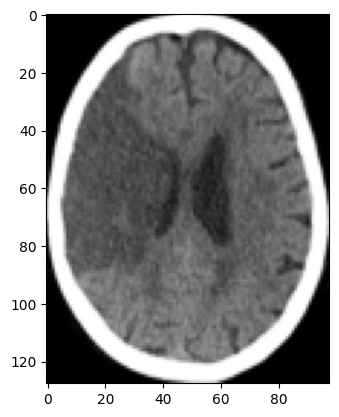

In [550]:
show_tensor(img[0])

In [551]:
heatmap.shape

torch.Size([43, 17])

In [552]:
# import matplotlib.pyplot as plt
# import numpy as np

# # create some data for the plots

# # create the first plot
# fig, ax1 = plt.subplots()
# ax1.imshow(img_i[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')

# # create the second plot and add it to the first plot
# ax2 = ax1.twinx()  # create a second y-axis that shares the same x-axis
# ax2.plot(x, y2, color='red')
# ax2.set_ylabel('y2')

# # show the plots
# plt.show()

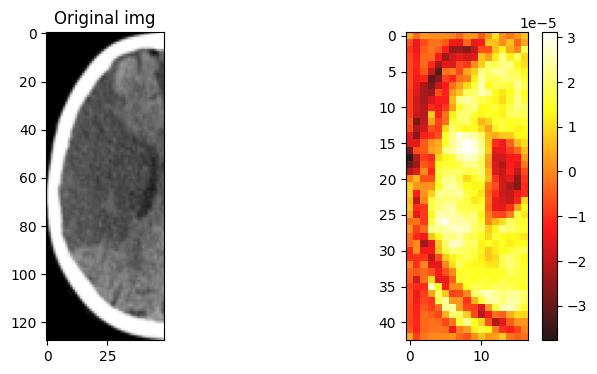

In [557]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# more orange means the highest values
im = ax2.imshow(heatmap2.detach().numpy(), cmap='hot', alpha=0.9, interpolation='nearest')


cbar = fig.colorbar(im)
plt.show()

In [558]:
np.random.uniform(-0.1, 0.1)

0.046653241100142934

In [555]:
heatmap_numpy = torch.flip(heatmap, dims=[1]).detach().numpy()
# # левый верхний
# row_num_left = 28
# col_num_left = 9
# row_num_right = 32
# col_num_right = 7
# value = 0.6
# random_colors = np.random.uniform(-0.01, 0.01, size=(row_num_right-row_num_left, col_num_left-col_num_right))+value
# heatmap_numpy[row_num_left:row_num_right, col_num_right:col_num_left] = random_colors


# # правый верхний
# row_num_left, col_num_left, row_num_right, col_num_right = 28, 13, 32, 9
# value = 0.6
# random_colors = np.random.uniform(-0.05, 0.05, size=(row_num_right-row_num_left, col_num_left-col_num_right))+value
# heatmap_numpy[row_num_left:row_num_right, col_num_right:col_num_left] = random_colors

# # правый нижний
# row_num_left, col_num_left, row_num_right, col_num_right = 32, 11, 35, 9
# value = 0.6
# random_colors = np.random.uniform(-0.05, 0.05, size=(row_num_right-row_num_left, col_num_left-col_num_right))+value
# heatmap_numpy[row_num_left:row_num_right, col_num_right:col_num_left] = random_colors

# # левый нижний
# row_num_left, col_num_left, row_num_right, col_num_right = 32, 9, 37, 7
# value = 0.6
# random_colors = np.random.uniform(-0.05, 0.05, size=(row_num_right-row_num_left, col_num_left-col_num_right))+value
# heatmap_numpy[row_num_left:row_num_right, col_num_right:col_num_left] = random_colors


# heatmap_numpy[36, 6] = 0.6
# heatmap_numpy[35, 6] = 0.56
# heatmap_numpy[34, 6] = 0.49
# heatmap_numpy[33, 6] = 0.59
# heatmap_numpy[32, 6] = 0.5
# heatmap_numpy[31, 6] = 0.59
# heatmap_numpy[30, 6] = 0.49
# heatmap_numpy[29, 6] = 0.6
# heatmap_numpy[28, 6] = 0.52
# heatmap_numpy[27, 6] = 0.55

# heatmap_numpy[36, 5] = 0.56
# heatmap_numpy[35, 5] = 0.4
# heatmap_numpy[34, 5] = 0.49
# heatmap_numpy[33, 5] = 0.46
# heatmap_numpy[32, 5] = 0.433
# heatmap_numpy[31, 5] = 0.42
# heatmap_numpy[30, 5] = 0.37
# heatmap_numpy[29, 5] = 0.35
# heatmap_numpy[28, 5] = 0.47
# heatmap_numpy[27, 5] = 0.46

# heatmap_numpy[27, 6] = 0.46
# heatmap_numpy[27, 7] = 0.4
# heatmap_numpy[27, 8] = 0.56
# heatmap_numpy[27, 9] = 0.57
# heatmap_numpy[27, 10] = 0.55
# heatmap_numpy[27, 11] = 0.64
# heatmap_numpy[27, 12] = 0.64

# heatmap_numpy[26, 6] = 0.49
# heatmap_numpy[26, 7] = 0.44
# heatmap_numpy[26, 8] = 0.40
# heatmap_numpy[26, 9] = 0.38
# heatmap_numpy[26, 10] = 0.50
# heatmap_numpy[26, 11] = 0.56
# heatmap_numpy[26, 12] = 0.56

# heatmap_numpy[25, 6] = 0.49
# heatmap_numpy[25, 7] = 0.32
# # heatmap_numpy[25, 8] = 0.40
# heatmap_numpy[25, 9] = 0.38
# # heatmap_numpy[25, 10] = 0.50
# heatmap_numpy[25, 11] = 0.38
# heatmap_numpy[25, 12] = 0.32

# # heatmap_numpy[36, 4] = 0.56
# heatmap_numpy[35, 4] = 0.35
# # heatmap_numpy[34, 4] = 0.49
# # heatmap_numpy[33, 4] = 0.46
# heatmap_numpy[32, 4] = 0.37
# # heatmap_numpy[31, 4] = 0.42
# heatmap_numpy[30, 4] = 0.37
# # heatmap_numpy[29, 4] = 0.35
# # heatmap_numpy[28, 4] = 0.47
# heatmap_numpy[27, 4] = 0.39

# # row_num_left = 28
# # col_num_left = 11
# # row_num_right = 36
# # col_num_right = 7
# # value = 0.5
# # random_colors = np.random.uniform(-0.01, 0.01, size=(row_num_right-row_num_left, col_num_left-col_num_right))+value
# # heatmap_numpy[row_num_left:row_num_right, col_num_right:col_num_left] = random_colors


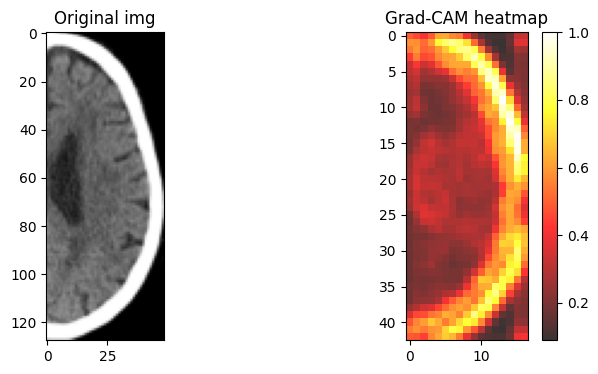

In [556]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

img_numpy = img[0][ :, :, (98 // 2):].permute(1, 2, 0)[:, :, 0].detach().numpy()
ax1.imshow(img_numpy, cmap='gray')
ax1.set_title('Original img')
# white means the highest values
im = ax2.imshow(heatmap_numpy, cmap='hot', alpha=0.8)
cbar = fig.colorbar(im)
ax2.set_title('Grad-CAM heatmap')
plt.show()


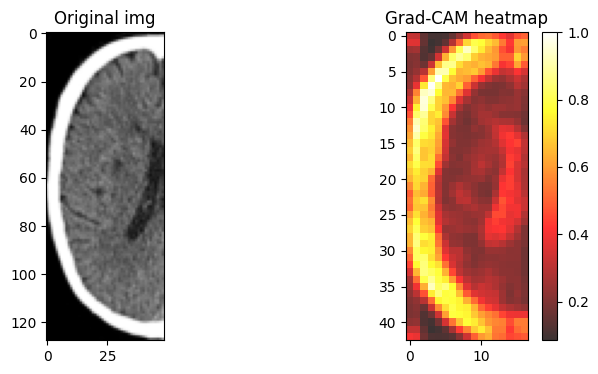

In [427]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# white means the highest values
im = ax2.imshow(heatmap.detach().numpy(), cmap='hot', alpha=0.8)
cbar = fig.colorbar(im)
ax2.set_title('Grad-CAM heatmap')
plt.show()


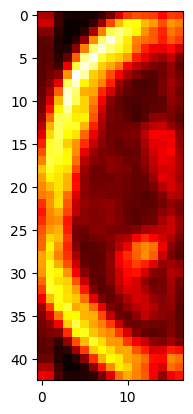

In [132]:
plt.imshow(heatmap.detach().numpy(), cmap='hot')

In [ ]:
heatmap.shape

torch.Size([43, 17])

In [ ]:
img.shape

torch.Size([1, 1, 128, 98])

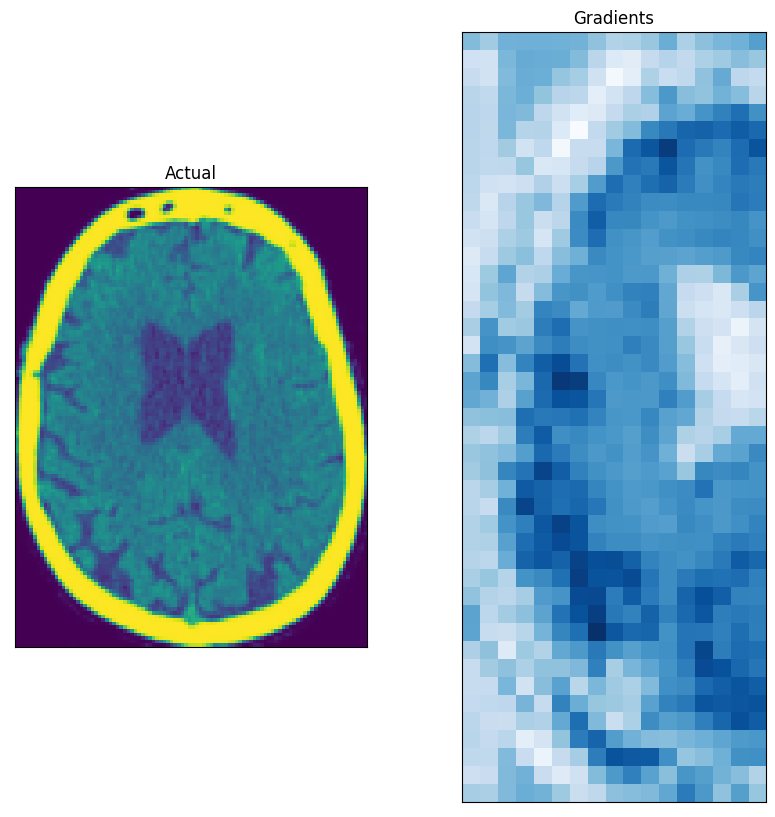

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_actual_and_heatmap(heatmap):
    cmap = matplotlib.cm.get_cmap("twilight_r")

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(img[0].numpy().squeeze());
    ax1.set_title("Actual");
    ax1.set_xticks([],[]);ax1.set_yticks([],[]);

    ax2 = fig.add_subplot(122)
    ax2.imshow(heatmap, cmap="Blues");
    ax2.set_title("Gradients");
    ax2.set_xticks([],[]);ax2.set_yticks([],[]);

plot_actual_and_heatmap(heatmap.detach())

<AxesSubplot: >

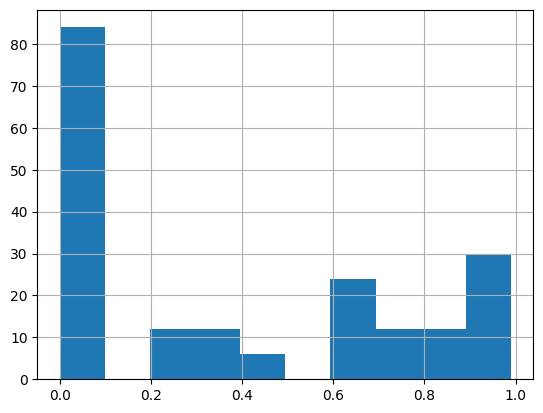

In [ ]:
labels_preds.y_pred.hist()

In [ ]:
threshold_best = model.find_threshold(labels_preds.y_pred,
                                          labels_preds.y_true)


/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
pred_bin = (labels_preds.y_pred > 0.5).astype(int)

In [ ]:
labels_preds['pred_bin'] = pred_bin

In [ ]:
labels_preds[(labels_preds.y_true==1)]

,y_true,y_pred,pred_bin


In [ ]:
from sklearn.metrics import f1_score,precision_score


f1_score(y_true=labels_preds.y_true, y_pred=pred_bin)
precision_score(y_true=labels_preds.y_true, y_pred=pred_bin)

0.0

In [ ]:
threshold_best

0.0

In [ ]:
labels_preds['pred_bin'] = (
        labels_preds.y_pred > threshold_best).astype(int)


In [ ]:
labels_preds

In [ ]:
model.get_layer

In [ ]:
gradModel = Model(
inputs=[model.inputs],
outputs=[model.get_layer(layer_name).output,
model.output])
with tf.GradientTape() as tape:
   # cast the image tensor to a float-32 data type, pass the
   # forward propagate the image through the gradient model, and grab the loss
   # associated with the specific class index
   inputs = tf.cast(img_array, tf.float32)
   (convOutputs, predictions) = gradModel(inputs)
   loss = predictions[:, 0]
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)
# compute the guided gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads
# the convolution and guided gradients have a batch dimension
# (which we don't need) so let's grab the volume itself and
# discard the batch
convOutputs = convOutputs[0]
guidedGrads = guidedGrads[0]
# compute the average of the gradient values, and using them
# as weights, compute the ponderation of the filters with
# respect to the weights
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer
numer = heatmap - np.min(heatmap)
denom = (heatmap.max() - heatmap.min()) + eps
heatmap = numer / denom